In [1]:
import sys
import time
import numpy as np
import os.path as osp
import tensorflow as tf
import matplotlib.pyplot as plt

from tf_lab.fundamentals.utils import set_visible_GPUs
import tf_lab.point_clouds.in_out as pio
import tf_lab.models.point_net_based_AE as pnAE
from tf_lab.autopredictors.scripts.helper import shape_net_category_to_synth_id
from tf_lab.point_clouds.in_out import PointCloudDataSet
from tf_lab.point_clouds.point_net_ae import PointNetAutoEncoder
from tf_lab.point_clouds.autoencoder import Configuration as Conf

from tf_lab.autopredictors.evaluate.basics import eval_model, read_saved_epochs
from tf_lab.autopredictors.plotting.basics import plot_original_pclouds_vs_reconstructed,\
                                                  plot_train_val_test_curves, plot_reconstructions_at_epoch


from general_tools.in_out.basics import create_dir, delete_files_in_directory, files_in_subdirs
from geo_tool import Point_Cloud


/orions4-zfs/projects/lins2/Panos_Space/Git_Repos/geo_tool/solids/mesh.py:26: UserWarning: Mayavi library was not found. Some graphics utilities will be disabled.
  warnings.warn('Mayavi library was not found. Some graphics utilities will be disabled.')


In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
seed = 42
np.random.seed(seed)
tf.set_random_seed(seed)

top_data_dir = '/orions4-zfs/projects/lins2/Panos_Space/DATA/'
full_pclouds_path = osp.join(top_data_dir, 'ShapeNetPointClouds/from_manifold_meshes/1024/')

experiment_name = 'enc_filter_1_complex_decode_full_SN'
train_dir = osp.join(top_data_dir, 'OUT/models/vanilla_ae')
train_dir = osp.join(train_dir, experiment_name)
create_dir(train_dir)

'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/vanilla_ae/enc_filter_1_complex_decode_full_SN'

In [4]:
full_file_names = pio.load_filenames_of_input_data(full_pclouds_path)
full_pclouds, full_model_names, class_ids = pio.load_crude_point_clouds(file_names=full_file_names, n_threads=11)
print '%d files containing complete point clouds were found.' % (len(full_pclouds), )

52103 files containing complete point clouds were found.


In [5]:
train_data_, val_data_, test_data_ = pio.train_validate_test_split([full_pclouds,                                                             
                                                            full_model_names],
                                                            train_perc=0.8,
                                                            validate_perc=0.1,
                                                            test_perc=0.1,
                                                            seed=seed)

train_data = PointCloudDataSet(train_data_[0], labels=train_data_[1])
val_data = PointCloudDataSet(val_data_[0], labels=val_data_[1])
test_data = PointCloudDataSet(test_data_[0], labels=test_data_[1])

In [ ]:
def reset_graph():
    if 'sess' in globals() and sess:
        sess.close()
    tf.reset_default_graph()

set_visible_GPUs([3])

conf = Conf(n_input = [1024, 3],
               training_epochs = 1000,
               batch_size = 80,
               loss = 'Chamfer',
               train_dir = train_dir,
               loss_display_step = 1,
               saver_step = 5,
               learning_rate = 0.00002,
               saver_max_to_keep = 200,
               gauss_augment = {'mu': 0,'sigma': 0.02},
               encoder = pnAE.encoder,
               decoder = pnAE.decoder
               )

reset_graph()
ae = PointNetAutoEncoder(experiment_name, conf)

In [ ]:
ae.train(train_data, conf)

('Epoch:', '0001', 'training time (minutes)=', '1.7306', 'loss=', '0.019921639')
('Epoch:', '0002', 'training time (minutes)=', '1.6612', 'loss=', '0.006708828')

In [11]:
saved_epochs = read_saved_epochs(conf.train_dir)
epochs = saved_epochs[::len(saved_epochs)/20]
stats = eval_model(ae, conf, [train_data, test_data, val_data], epochs=epochs, verbose=True)

'/orions4-zfs/projects/lins2/Panos_Space/DATA/OUT/models/vanilla_ae/enc_filter_1_complex_decoder_full_SN'

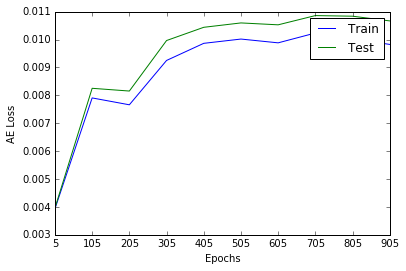

In [35]:
# top_save_dir = osp.join(top_data_dir, 'OUT/model_evaluation/incomplete_pclouds/virt_scan_03001627_only_ae/')

top_save_dir = osp.join(top_data_dir, 'OUT/model_evaluation/incomplete_pclouds/blensor_data/')
plot_train_val_test_curves(stats, top_save_dir, has_validation=False, best_epoch=None, show=True)

In [52]:
best_epoch = 185
save_dir = osp.join(top_save_dir, 'test_images_epoch_' + str(best_epoch))
plot_reconstructions_at_epoch(best_epoch, ae, test_data, conf, save_dir=save_dir, max_plot=200)

last_epoch = saved_epochs[-1]
save_dir = osp.join(top_save_dir, 'train_images_epoch_' + str(last_epoch))
plot_reconstructions_at_epoch(last_epoch, ae, train_data, conf, save_dir=save_dir, max_plot=200)